In [143]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Исследование распределения космических спутников по орбитам в зависимости от их предназначения.
Задача: выявить какие существуют группы спутников по предназначению, когда они были запущены, какие характерные орбиты для каждой группы, попробовать сделать выводы чем такое расположение может быть обосновано.

Для сбора данных был использован сайт https://www.n2yo.com/satellites/, данные собирались скрэпингом. Для начала откроем датасет и посмотрим какие данные нам пришли.

In [117]:
data = pd.read_csv(filepath_or_buffer='data/sat.csv')
data.head(10)

,name,category,NORAD ID,Int'l Code,Perigee,Apogee,Inclination,Period,Semi major axis,RCS,Launch date,Source,Launch site
0,NAVSTAR 33 (USA 92),Global Positioning System (GPS) Constellation,22700,1993-042A,"21,195.2 km","21,244.6 km",55.0 &deg,760.2 minutes,27590 km,3.4011 m,1993,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR)
1,FLOCK 1C 10,Flock,40023,2014-033P,595.1 km,614.5 km,97.9 &deg,96.6 minutes,6975 km,Unknown,2014,United States (US),"Orenburg, Russia (OREN)"
2,FLOCK 1C 7,CubeSats,40026,2014-033S,593.9 km,611.0 km,97.9 &deg,96.6 minutes,6973 km,Unknown,2014,United States (US),"Orenburg, Russia (OREN)"
3,FLOCK 1C 1,CubeSats,40027,2014-033T,595.0 km,614.3 km,97.9 &deg,96.6 minutes,6975 km,Unknown,2014,United States (US),"Orenburg, Russia (OREN)"
4,RADIO 8,Amateur radio,12998,1981-120B,"1,659.3 km","1,688.5 km",83.0 &deg,119.7 minutes,8044 km,0.8671 m,1981,Commonwealth of Independent States (former USS...,PLESETSK MISSILE AND SPACE COMPLEX (PKMTR)
5,CHINASAT 6A,Geostationary,37150,2010-042A,"35,790.8 km","35,797.4 km",0.0 &deg,"1,436.1 minutes",42165 km,50.1187 m,2010,People's Republic of China (PRC),"Xichang Space Center, China (XSC)"
6,ODERACS C,Engineering,22992,1994-006D,NaN,NaN,NaN,NaN,NaN,NaN,1994,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR)
7,SJ-11-05,Experimental,39202,2013-035A,689.9 km,705.2 km,98.1 &deg,98.6 minutes,7068 km,Unknown,2013,People's Republic of China (PRC),"Jiuquan Satellite Launch Center, China (JSC)"
8,SYNCOM 1,Geostationary,553,1963-004A,"29,017.8 km","34,551.2 km",31.1 &deg,"1,236.2 minutes",38155 km,0.003 m,1963,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR)
9,CELESTIS 04/TAURUS R/B,Celestis,26034,1999-070C,534.8 km,551.5 km,98.2 &deg,95.4 minutes,6914 km,1.2202 m,1999,United States (US),AIR FORCE WESTERN TEST RANGE (AFWTR)


Как можно заметить, данные пришли довольно "грязные": расстояния даны с подписью km, время обозначено минутами, градусы попровождаются &deg.
Все дело в том, что автор не очень-то запаривался когда писал парсер и тянул с сайта сырые данные) Поэтому первым делом надо оставить в колонках только численные значения.

In [118]:
data.dropna(inplace=True)
data['Perigee'] = data['Perigee'].astype(str).transform(lambda s: float(s.replace(',','').split()[0]))
data['Apogee'] = data['Apogee'].astype(str).transform(lambda s: float(s.replace(',','').split()[0]))
data['Inclination'] = data['Inclination'].astype(str).transform(lambda s: float(s.replace(',','').split()[0]))
data['Period'] = data['Period'].astype(str).transform(lambda s: float(s.replace(',','').split()[0]))
data['Semi major axis'] = data['Semi major axis'].astype(str).transform(lambda s: float(s.replace(',','').split()[0]))
data.head()

,name,category,NORAD ID,Int'l Code,Perigee,Apogee,Inclination,Period,Semi major axis,RCS,Launch date,Source,Launch site
0,NAVSTAR 33 (USA 92),Global Positioning System (GPS) Constellation,22700,1993-042A,21195.2,21244.6,55.0,760.2,27590.0,3.4011 m,1993,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR)
1,FLOCK 1C 10,Flock,40023,2014-033P,595.1,614.5,97.9,96.6,6975.0,Unknown,2014,United States (US),"Orenburg, Russia (OREN)"
2,FLOCK 1C 7,CubeSats,40026,2014-033S,593.9,611.0,97.9,96.6,6973.0,Unknown,2014,United States (US),"Orenburg, Russia (OREN)"
3,FLOCK 1C 1,CubeSats,40027,2014-033T,595.0,614.3,97.9,96.6,6975.0,Unknown,2014,United States (US),"Orenburg, Russia (OREN)"
4,RADIO 8,Amateur radio,12998,1981-120B,1659.3,1688.5,83.0,119.7,8044.0,0.8671 m,1981,Commonwealth of Independent States (former USS...,PLESETSK MISSILE AND SPACE COMPLEX (PKMTR)


Удалим столбцы Int'l Code и RCS, для исследования они не понадобятся.

In [119]:
data.drop(columns=['Int\'l Code', 'RCS'], inplace=True)
data.head()

,name,category,NORAD ID,Perigee,Apogee,Inclination,Period,Semi major axis,Launch date,Source,Launch site
0,NAVSTAR 33 (USA 92),Global Positioning System (GPS) Constellation,22700,21195.2,21244.6,55.0,760.2,27590.0,1993,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR)
1,FLOCK 1C 10,Flock,40023,595.1,614.5,97.9,96.6,6975.0,2014,United States (US),"Orenburg, Russia (OREN)"
2,FLOCK 1C 7,CubeSats,40026,593.9,611.0,97.9,96.6,6973.0,2014,United States (US),"Orenburg, Russia (OREN)"
3,FLOCK 1C 1,CubeSats,40027,595.0,614.3,97.9,96.6,6975.0,2014,United States (US),"Orenburg, Russia (OREN)"
4,RADIO 8,Amateur radio,12998,1659.3,1688.5,83.0,119.7,8044.0,1981,Commonwealth of Independent States (former USS...,PLESETSK MISSILE AND SPACE COMPLEX (PKMTR)


NORAD ID - уникальный номер каждого космического аппарата. В процессе он может пригодиться чтобы извлекать информацию про конкретные космические аппараты.

Выясним, есть ли в датасете повторяющиеся космические аппараты:

In [120]:
data.groupby(['NORAD ID']).count().sort_values(by='category', ascending=False).head()

,name,category,Perigee,Apogee,Inclination,Period,Semi major axis,Launch date,Source,Launch site
NORAD ID,,,,,,,,,,
5,1,1,1,1,1,1,1,1,1,1
38331,1,1,1,1,1,1,1,1,1,1
38352,1,1,1,1,1,1,1,1,1,1
38342,1,1,1,1,1,1,1,1,1,1
38340,1,1,1,1,1,1,1,1,1,1


Как оказалось, повторений в таблице нет. Лично я ожидал увидеть немного другой результат, так как на сайте были аппараты относящиеся к разным категориям. Теперь посмотрим в какие годы были запущены исследуемые аппараты:

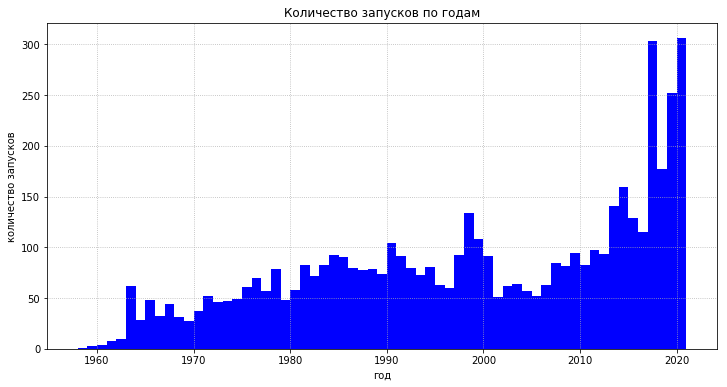

In [121]:
df = data['Launch date']
sorted_date = data['Launch date'].sort_values()
first_year, last_year = sorted_date.iloc[0], sorted_date.iloc[-1]

plt.figure(figsize=(12,6))
plt.hist(
    np.array(df),
    bins=np.linspace(first_year, last_year+1, last_year-first_year+2),
    color='blue')
plt.title('Количество запусков по годам')
plt.ylabel('количество запусков')
plt.xlabel('год')
plt.grid(ls=':')
plt.show()

Перейдем непосрественно к изучению интересующего нас вопроса. Для начала получим список категорий и распределение аппаратов по категориям:

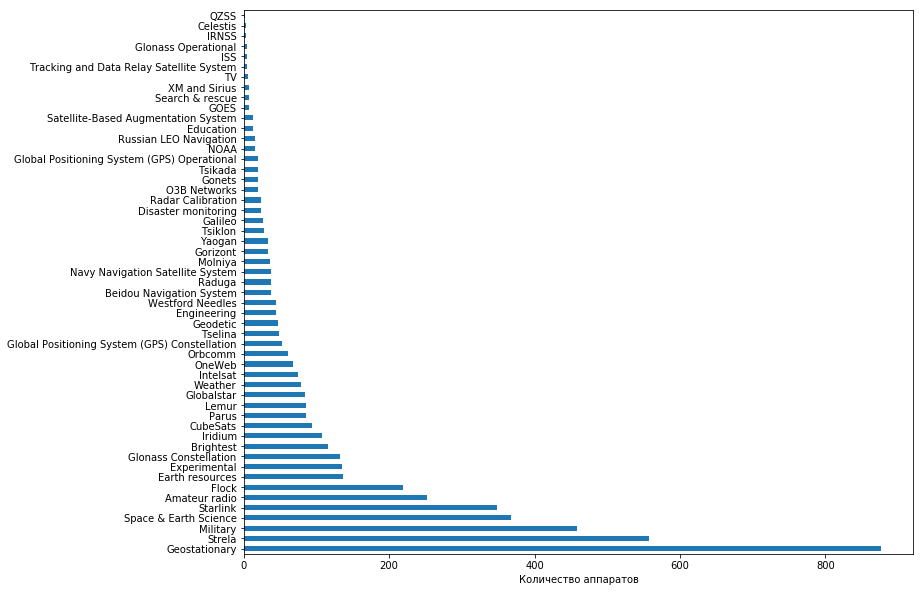

In [122]:
plt.figure(figsize=(12,10))
data['category'].value_counts().plot(kind='barh')
plt.xlabel('Количество аппаратов')
plt.show()

Как видно по графику выше, категории имеющиеся в датасете не обязательно отражают предназначение аппарата: тут есть и названия крупных семейств спутников (Strela, Starlink, Iridium и др.), также в списке оказалась категория Brightest, в которой на сайте были отмечены самые яркие объекты. Самая крупная категория спутников - Geostationary - и вовсе не отражает предназначение объектов, а только указывает что они находятся на геостационарной орбите. Более того, как отдельная категория выделена Международная Космическая Станция (ISS).

In [123]:
data[data['category']=='ISS']

,name,category,NORAD ID,Perigee,Apogee,Inclination,Period,Semi major axis,Launch date,Source,Launch site
4885,PROGRESS MS-13,ISS,44833,424.6,426.8,51.6,92.9,6796.0,2019,Commonwealth of Independent States (former USS...,TYURATAM MISSILE AND SPACE COMPLEX (TTMTR)
4886,CYGNUS NG-13,ISS,45175,482.8,490.4,51.6,94.2,6857.0,2020,United States (US),WALLOPS ISLAND (WLPIS)
4887,SOYUZ MS-16,ISS,45476,424.6,426.8,51.6,92.9,6796.0,2020,Commonwealth of Independent States (former USS...,TYURATAM MISSILE AND SPACE COMPLEX (TTMTR)
4888,PROGRESS MS-14,ISS,45595,424.6,426.8,51.6,92.9,6796.0,2020,Commonwealth of Independent States (former USS...,TYURATAM MISSILE AND SPACE COMPLEX (TTMTR)


Точнее сама космическая станция в список не попала - попали несколько космических кораблей пристыкованных к ней в данный момент.

Одной из главных характеристик орбиты является её большая полуось (Semi major axis), которая определяется как половина большой оси эллипса орбиты. Проще говоря, большая полуось показывает насколько высоко находится та или иная орбита, и в случае с круговыми орбитами численно совпадает с их радиусом. Также именно большая полуось определяет период обращения аппарата.
Посмотрим какой диапазон больших полуосей орбит есть в нашем датасете.

In [124]:
smj_axes = data['Semi major axis'].sort_values()
smj_axes.iloc[0], smj_axes.iloc[-1]

(6629.0, 210769.0)

Посмотрим какие аппараты летают выше всего

In [125]:
data.sort_values(by='Semi major axis', ascending=False).head(10)

,name,category,NORAD ID,Perigee,Apogee,Inclination,Period,Semi major axis,Launch date,Source,Launch site
3884,BERESHEET,Space & Earth Science,44049,1268.5,407528.1,25.0,16049.8,210769.0,2019,Israel (ISRA),AIR FORCE EASTERN TEST RANGE (AFETR)
1841,LONGJIANG 1,Space & Earth Science,43471,402.0,383116.8,27.5,14628.0,198130.0,2018,People's Republic of China (PRC),"Xichang Space Center, China (XSC)"
3773,IBEX,Space & Earth Science,33401,43057.9,333439.0,30.2,14240.9,194619.0,2008,United States (US),Pegasus launched from Western Range Air Space ...
3820,SPEKTR R,Space & Earth Science,37755,16273.1,345507.9,61.7,13441.0,187261.0,2011,Commonwealth of Independent States (former USS...,TYURATAM MISSILE AND SPACE COMPLEX (TTMTR)
3874,TESS,Space & Earth Science,43435,1062.9,355646.0,28.9,13168.9,184725.0,2018,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR)
3523,GEOTAIL,Space & Earth Science,22049,48593.7,192427.1,27.3,7496.5,126881.0,1992,Japan (JPN),AIR FORCE EASTERN TEST RANGE (AFETR)
4430,OPS 6577 (VELA 5),Military,1458,53175.4,170894.2,21.3,6758.0,118405.0,1965,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR)
4429,OPS 6564 (VELA 6),Military,1459,54726.4,169106.9,28.1,6747.9,118287.0,1965,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR)
4479,OPS 7033 (VELA 11),Military,4368,9663.6,213043.6,51.9,6699.8,117724.0,1970,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR)
4473,OPS 6909 (VELA 9),Military,3954,16239.2,206361.0,34.8,6695.2,117671.0,1969,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR)


Как видно, самые высокие орбиты имеют научные аппараты, далее на высоте в 120 тыс км находятся американские военные спутники 60-х годов постройки.
Построим график плотности распределения спутников по высоте орбиты.

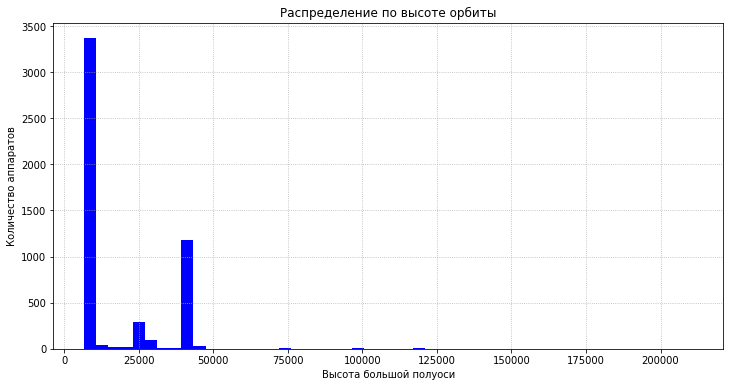

In [126]:
plt.figure(figsize=(12,6))
plt.hist(
    data['Semi major axis'],
    bins=50,
    color='blue')
plt.title('Распределение по высоте орбиты')
plt.ylabel('Количество аппаратов')
plt.xlabel('Высота большой полуоси')
plt.grid(ls=':')
plt.show()

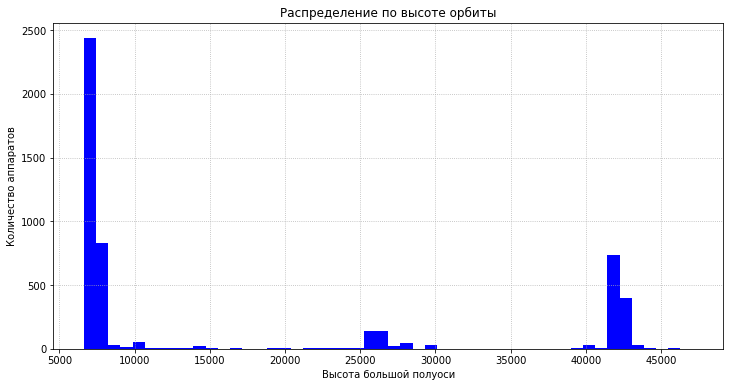

In [127]:
# уменьшим немного верхнюю границу высоты
plt.figure(figsize=(12,6))
plt.hist(
    data[data['Semi major axis']<50000]['Semi major axis'],
    bins=50,
    color='blue')
plt.title('Распределение по высоте орбиты')
plt.ylabel('Количество аппаратов')
plt.xlabel('Высота большой полуоси')
plt.grid(ls=':')
plt.show()

Здесь видно, что спутники по большей части распределены на три группы: подавляющее большинство на низких околоземных орбитах (7000-8000км), поменьше на орбитах 42000-43000км и небольшая группа с орбитами чуть выше 25000.

Для построения более детального распределения по орбитам будем использовать следующие характеристики: большую полуось (Semi Major Axis) и наклонение к плоскости экватора (Inclination). Построим на графике все аппараты из датасета и попробуем выделить какие-то специфичные типы орбит.

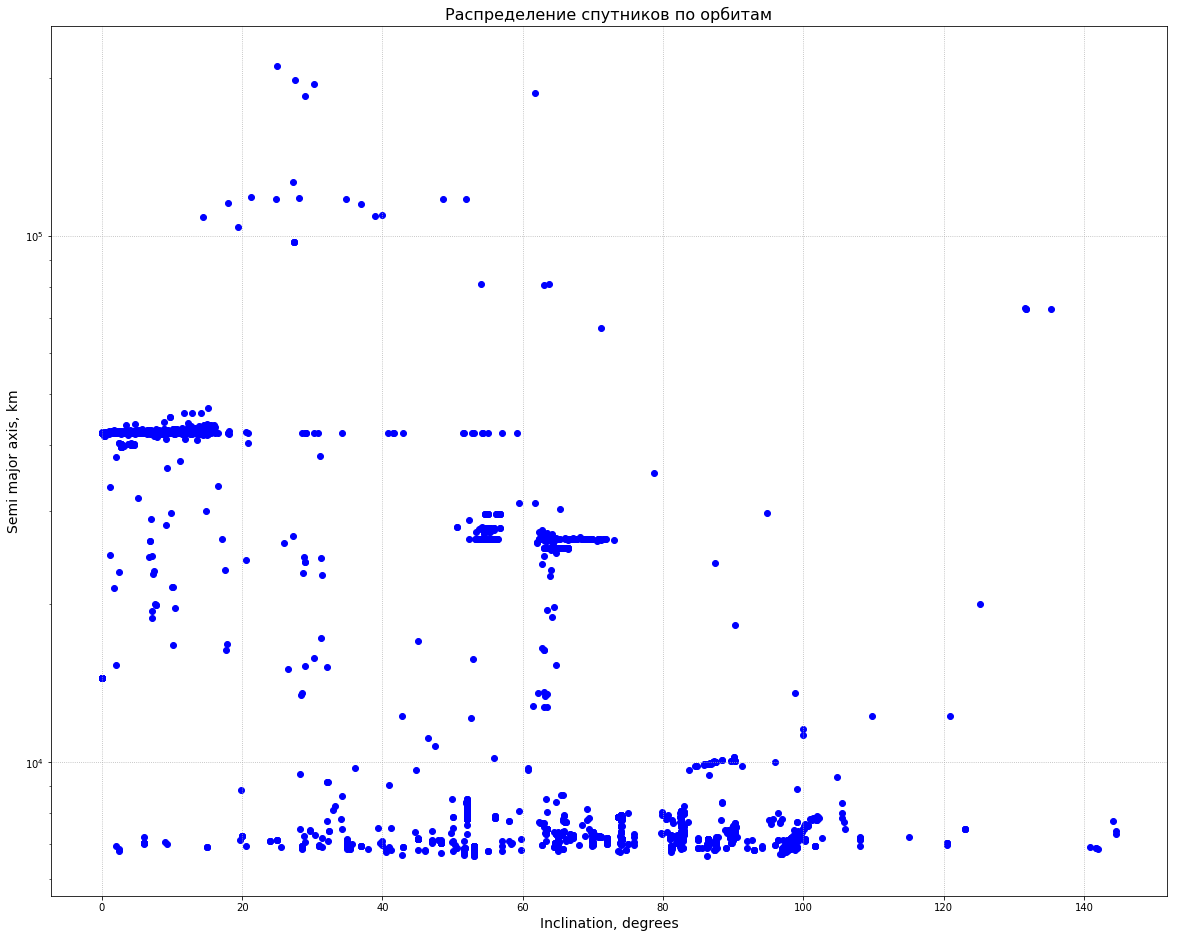

In [138]:
from matplotlib.ticker import LogFormatter
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)
ax.scatter(
    data['Inclination'],
    data['Semi major axis'],
    color = 'blue')
ax.set_title('Распределение спутников по орбитам', fontsize=16)
ax.set_xlabel('Inclination, degrees', fontsize=14)
ax.set_ylabel('Semi major axis, km', fontsize=14)
formatter = LogFormatter(labelOnlyBase=False)
ax.get_yaxis().set_minor_formatter(formatter)
ax.set_yscale('log')
plt.grid(ls=':')
plt.show()

На графике отчетливо прослеживаются две горизонтальные линии: на уровне в 42 тыс км и ~28 тыс км соответственно. При этом по наклонению орбиты особых закономерностей не наблюдается.

Попробуем поисследовать что за аппараты находятся на этих двух линиях:

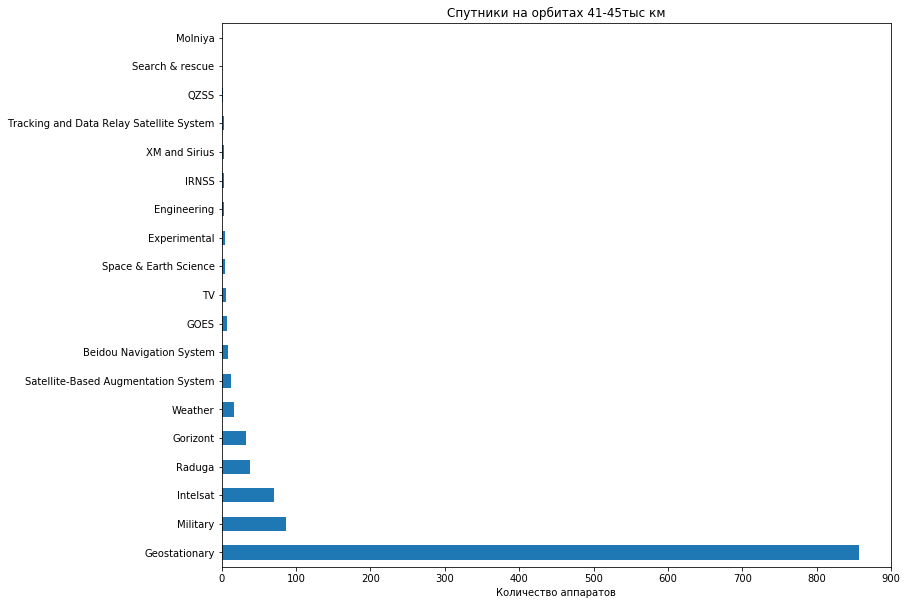

In [129]:
df = data[(data['Semi major axis']>41000) & (data['Semi major axis']<44000)]
plt.figure(figsize=(12,10))
df['category'].value_counts().plot(kind='barh')
plt.title('Спутники на орбитах 41-45тыс км')
plt.xlabel('Количество аппаратов')
plt.show()

Как видно, подавляющая часть аппаратов имеет категорию Geostationary. Дело в том, что как раз в выделенном диапазоне находится геостационарная орбита - та на которой период обращения равен длине суток, благодаря чему спутник неподвижен для наблюдателя с Земли. В частности именно таковыми являются телевизионные спутники, что тоже видно выше.

Изучим теперь что находится на орбитах 25-30 тыс. км:

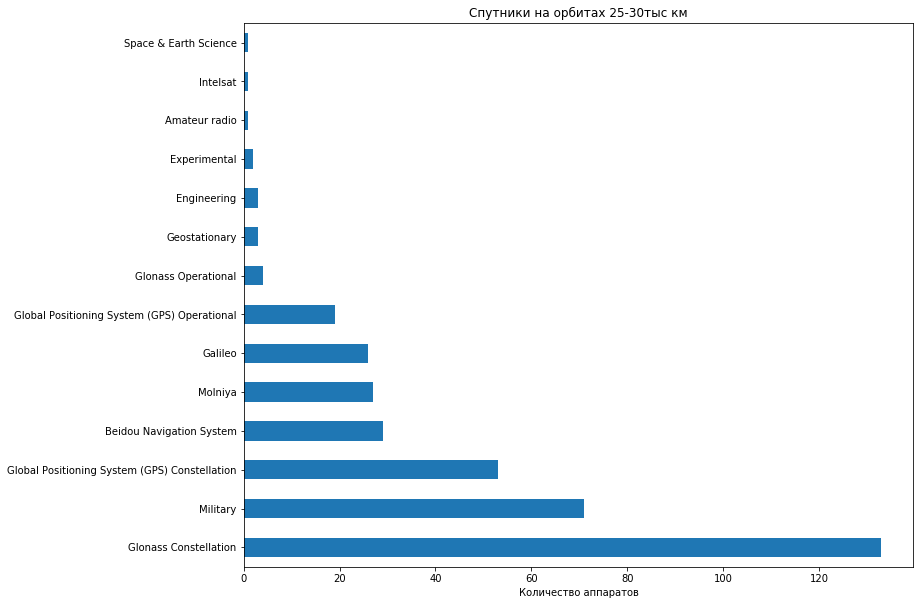

In [130]:
df = data[(data['Semi major axis']>25000) & (data['Semi major axis']<30000)]
plt.figure(figsize=(12,10))
df['category'].value_counts().plot(kind='barh')
plt.title('Спутники на орбитах 25-30тыс км')
plt.xlabel('Количество аппаратов')
plt.show()

Здесь мы видим, что диапазон орбит 25-30 тыс. км. используется преимущественно навигационными спутниками.

Еще одна интересная характеристика орбиты - эксцентриситет. Она показывает, насколько сильно "вытянута" орбита. Для круговых орбит эксцентриситет равен 0, а при значении эксцентриситета 1 орбита вырождается в параболу.
Рассчитывать его мы будем по формуле $\epsilon = (R + H)/a - 1$, где $R$ - радиус Земли, $H$ - высота в апогее (Apogee), $a$ - большая полуось. 

In [131]:
earth_R = 6371.0
data['eccentricity'] = (data['Apogee'] + earth_R)/data['Semi major axis'] - 1
data.head()

,name,category,NORAD ID,Perigee,Apogee,Inclination,Period,Semi major axis,Launch date,Source,Launch site,eccentricity
0,NAVSTAR 33 (USA 92),Global Positioning System (GPS) Constellation,22700,21195.2,21244.6,55.0,760.2,27590.0,1993,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR),0.000928
1,FLOCK 1C 10,Flock,40023,595.1,614.5,97.9,96.6,6975.0,2014,United States (US),"Orenburg, Russia (OREN)",0.001505
2,FLOCK 1C 7,CubeSats,40026,593.9,611.0,97.9,96.6,6973.0,2014,United States (US),"Orenburg, Russia (OREN)",0.001291
3,FLOCK 1C 1,CubeSats,40027,595.0,614.3,97.9,96.6,6975.0,2014,United States (US),"Orenburg, Russia (OREN)",0.001477
4,RADIO 8,Amateur radio,12998,1659.3,1688.5,83.0,119.7,8044.0,1981,Commonwealth of Independent States (former USS...,PLESETSK MISSILE AND SPACE COMPLEX (PKMTR),0.001927


Посмотрим, какие же аппараты имеют орбиты с наибольшим эксцентриситетом.

In [132]:
data.sort_values(by='eccentricity', ascending=False).head(15)

,name,category,NORAD ID,Perigee,Apogee,Inclination,Period,Semi major axis,Launch date,Source,Launch site,eccentricity
1841,LONGJIANG 1,Space & Earth Science,43471,402.0,383116.8,27.5,14628.0,198130.0,2018,People's Republic of China (PRC),"Xichang Space Center, China (XSC)",0.965819
3884,BERESHEET,Space & Earth Science,44049,1268.5,407528.1,25.0,16049.8,210769.0,2019,Israel (ISRA),AIR FORCE EASTERN TEST RANGE (AFETR),0.963757
3874,TESS,Space & Earth Science,43435,1062.9,355646.0,28.9,13168.9,184725.0,2018,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR),0.959762
3838,MARS ORBITER MISSION,Space & Earth Science,39370,853.1,194683.1,19.4,5574.2,104139.0,2013,India (IND),SRIHARIKOTA (SRI),0.930632
3415,ASTRON,Space & Earth Science,13901,2501.5,201720.6,14.4,5926.5,108482.0,1983,Commonwealth of Independent States (former USS...,TYURATAM MISSILE AND SPACE COMPLEX (TTMTR),0.918213
3655,INTEGRAL,Space & Earth Science,27540,2139.3,147335.2,54.1,3831.4,81108.0,2002,European Space Agency (ESA),TYURATAM MISSILE AND SPACE COMPLEX (TTMTR),0.895081
3098,OGO 1,Space & Earth Science,879,2441.5,146617.2,63.8,3816.7,80900.0,1964,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR),0.891078
3820,SPEKTR R,Space & Earth Science,37755,16273.1,345507.9,61.7,13441.0,187261.0,2011,Commonwealth of Independent States (former USS...,TYURATAM MISSILE AND SPACE COMPLEX (TTMTR),0.879083
4478,OPS 7044 (VELA 12),Military,4366,8065.4,214164.0,48.7,6679.4,117485.0,1970,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR),0.877133
3854,MMS 1,Space & Earth Science,40482,6494.5,175276.1,27.4,5030.8,97256.0,2015,United States (US),AIR FORCE EASTERN TEST RANGE (AFETR),0.867721


Видим что большая часть аппаратов с большим эксцентриситетом - научные, причем большие полуоси их орбит превосходят 90 тысяч километров. Немного погуглив я выяснил, что первые два аппарата были частью миссий к Луне, что подтверждает тот факт, что их апогей близок к радиусу лунной орбиты.

Теперь выделим несколько больших групп космических аппаратов и посмотрим как они распределены на графике "Большая полуось - Наклонение".
Группы получились следующие:
* Навигационные:
* Коммуникационные:
* Прогноз погоды:
* Военные
* Наблюдение за землей:
* Научно-исследовательские


In [140]:
navigation = ['Global Positioning System (GPS) Constellation', 
              'Global Positioning System (GPS) Operational', 
              'Glonass Constellation',
              'Glonass Operational',
              'Beidou Navigation System',
              'Navy Navigation Satellite System',
              'Galileo',
              'Parus']
communication = ['TV',
                 'Iridium',
                 'Starlink',
                 'Globalstar',
                 'OneWeb',
                 'Intelsat',
                 'Orbcomm',
                 'Gorizont']
weather = ['Weather',
           'NOAA',
           'Disaster monitoring',
           'Lemur']
observation = ['Flock', 'Geodetic', 'Earth resources']
military = ['Strela',
            'Molniya',
            'Tsiklon',
            'Yaogan']
for tag in navigation:
    data.replace(tag, 'Navigation', inplace=True)
for tag in communication:
    data.replace(tag, 'Communication', inplace=True)
for tag in weather:
    data.replace(tag, 'Weather', inplace=True)
for tag in military:
    data.replace(tag, 'Military', inplace=True)
for tag in observation:
    data.replace(tag, 'Observation', inplace=True)

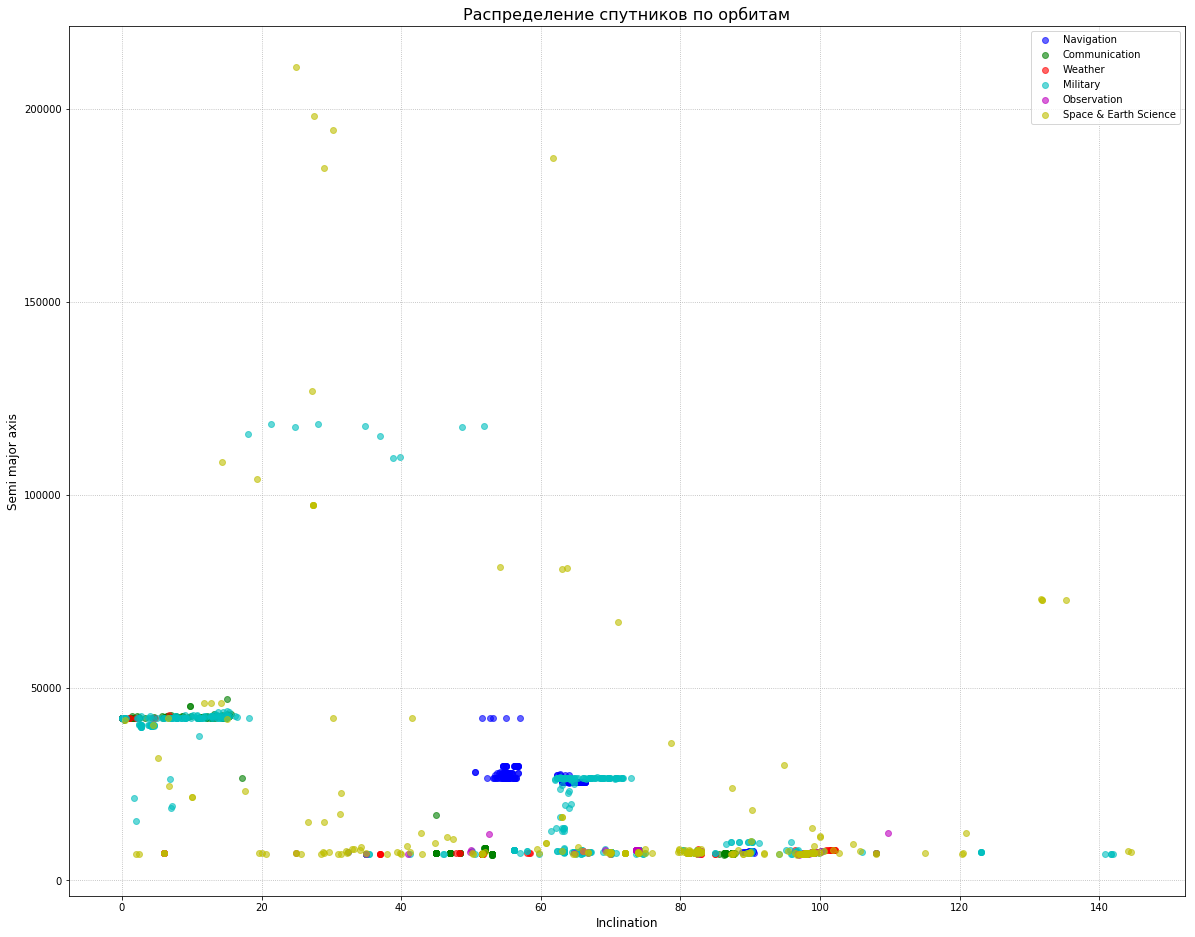

In [141]:
categories = ['Navigation', 'Communication', 'Weather', 'Military', 'Observation', 'Space & Earth Science']
color_seq = ['b', 'g', 'r', 'c', 'm', 'y']
plt.figure(figsize=(20, 16))
for cat, clr in zip(categories, color_seq):
    plt.scatter(
    data[data['category']==cat]['Inclination'],
    data[data['category']==cat]['Semi major axis'],
    label = cat,
    color = clr,
    alpha = 0.6)
plt.title('Распределение спутников по орбитам', fontsize=16)
plt.xlabel('Inclination', fontsize=12)
plt.ylabel('Semi major axis', fontsize=12)
#plt.yscale('log')
plt.legend()
plt.grid(ls=':')
plt.show()

На графике отлично видно три кластера навигационных спутников, расположенных около наклонения в 60 градусов, скопления военных и коммуникационных спутников. Примечательно тажке скопление метеорологических спутников на низкой орбите с наклонением около 100 градусов - это значит что они вращаются практически по полярным орбитам, причем в направлении противоположном направлению вращения Земли.

##### Итак, подведем итоги нашего исследования:
* Космические аппараты, находящиеся на орбите Земли имеют большую полуось орбиты от 6,6 тыс до 211 тыс км.
* Аппараты с наибольшей большой полуосью - исследовательские станции, также они же имеют наибольший эксцентриситет. В частности как минимум две из них совершали миссии к Луне.
* На орбитах около 120 тыс км находятся несколько американских военных спутников.
* Большинство космических аппаратов находятся на низких околоземных орбитах (до 8000км).
* Также выделяются еще две орбиты, имеющие полуоси около 28 тыс и 42 тыс километров соответственно. 
* Орбиты с полуосью в 28 тыс км используются навигационными спутниками, которые вращаются с наклонением чуть менее 60 градусов (GPS) и чуть более 60 градусов (Глонасс и остальные). Такой сильный наклон орбиты можно объяснить тем что спутники должны быть доступны в том числе и из полярных регионов. 
* Орбита с полуосью 42 тыс км является геостационарной и используется самыми разными спутниками, в первую очередь теми, для которых важно находиться над одной точкой поверхности Земли. Кроме того на этой же высоте с наклонением в 50-55 градусов находится еще кластер навигационных спутников.
* Метеорологические спутники разделены между геостационарной и низкой околоземной орбитами, причем на последней имеется кластер из нескольких спутников с наклонением около 100 градусов - возможно, они используются для наблюдения погоды в полярных регионах.
* Коммуникационные спутники также распределены между геостационарной и низкой околоземной орбитами. Это скорее всего связано с тем что фиксированное положение на геостационарной орбите облегчает наведение на спутник и установку соединения, в то время как низкие орбиты позволяют сократить задержку сигнала.
* Военные спутники кроме уже упомянутого кластера на орбитах высотой 120 тыс км также распределены на двух популярных орбитах в 42 и 28 тыс км соответственно. Такое расположение вероятно обусловлено использованием их для связи и навигации.